In [1]:
import function.functions as functions

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib
import sys

plt.rcParams['text.usetex'] = True
params = {
    "backend": "ps",
    "axes.labelsize": 22,
    "font.size": 22,
    "legend.fontsize": 10,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "legend.frameon": True,
    "savefig.dpi": 100,
    "axes.linewidth": 1.5,
    'xtick.major.size' : 10,
    'xtick.major.width': 1,
    'xtick.minor.size': 7,
    'xtick.minor.width': 1,
    'ytick.major.size' : 10,
    'ytick.major.width': 1,
    'ytick.minor.size': 7,
    'ytick.minor.width': 1,
    'axes.xmargin' : 0,
    'axes.ymargin' : 0,
}
plt.rcParams.update(params)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('text', usetex=True)

In [2]:
# Set device and parameters in this part

############################# Set parameters ##############################
device = 'charge_qubit' # change here to change the device: charge_qubit, flopping_spin, flopping_charge, transmon, fluxonium

device_module = importlib.import_module('parameters.' + device)
globals().update(vars(device_module)) # import parameters of the device

if device == 'charge_qubit':
    wlist = np.linspace(0,2*wq,101,endpoint=True)
    Alist_cut_SNR = np.linspace(0,1*wq,40)

else:
    print('device not implemented in this notebook')
    sys.exit()

ground, excited = 0, 1

qubit_state_list = [ground, excited]

tlist = np.linspace(0,.2/kappa,num=100)

compensation = False # set compensation True/False
###########################################################################

########################### Custom parameters #################################
# test other parameters Alist_cut_SNR, wlist

save_file = True # test mode or save data to generate the data of the figure of the paper
################################################################################

In [3]:
chi_disp, index_wr_low, index_wr_high = functions.search_optimal_dispersive(N_rep,0.01*wq,H_sys,g,drive_op,wq,wlist,n_states,num_A,ground,excited,kappa)

print(r'$\chi_{\text{disp}}/\kappa/2$='+str(chi_disp[index_wr_low]/(kappa/2))+', '+str(chi_disp[index_wr_high]/(kappa/2))\
      +r' obtained at $\omega_r/\omega_q$='+str(wlist[index_wr_low]/wq)+', '+str(wlist[index_wr_high]/wq))

list_index_wr = [index_wr_low,index_wr_high]

res_num_cut_SNR = np.zeros((len(Alist_cut_SNR),2), dtype=object)
res_an_cut_SNR= np.zeros((len(Alist_cut_SNR),2), dtype=object)

wlist_cut_SNR = [wlist[list_index_wr[0]], wlist[list_index_wr[1]]]

A_list, dd_real, dd2_real = functions.get_derivatives(N_rep,Alist_cut_SNR,H_sys,drive_op,wlist_cut_SNR,n_states,num_A)

for j, w_r in enumerate(wlist_cut_SNR):        
    for i, A_q in enumerate(Alist_cut_SNR):
        index_A = i

        g1 = g*dd_real[j,index_A,excited]
        g0 = g*dd_real[j,index_A,ground]

        chi1 = g**2*(dd2_real[j,index_A,excited]+1/A_q*dd_real[j,index_A,excited])
        chi0 = g**2*(dd2_real[j,index_A,ground]+1/A_q*dd_real[j,index_A,ground])

        g_parallel = 1/2*(g1-g0)
        chi = 1/2*(chi1-chi0)

        g_sum = 1/2*(g1+g0)
        chi_sum = 1/2*(chi1+chi0)

        if(compensation):
            w_d = w_r+chi_sum # shifted resonator frequency
            A_d = -2*g_sum # compensation tone
        else:
            w_d = w_r
            A_d = 0
        
        res_a_num = [[],[]]
        res_a_an = [[],[]]

        gamma = kappa*(g/(wq-w_r))**2 # Purcell

        for idx, qubit_state in enumerate(qubit_state_list):

            numerical_result = functions.real_time_dynamics(H_sys,A_q,A_d,w_r,w_d,0,g,drive_op,n_states,kappa,qubit_state,tlist,N_fock)

            z0 = functions.get_z0(N_rep,A_q,num_A,H_sys,drive_op,w_d,qubit_state,ground,excited,n_states)

            analytical_result = functions.analytical_time_dynamics(z0,w_r,w_d,A_d,0,g_parallel,g_sum,chi,chi_sum,kappa,gamma,tlist)

            res_a_num[idx].append(numerical_result)        
            res_a_an[idx].append(analytical_result)
        
        res_num_cut_SNR[i,j] = functions.generate_SNR_list(res_a_num,kappa,tlist)[-1]
        res_an_cut_SNR[i,j] = functions.generate_SNR_list(res_a_an,kappa,tlist)[-1]

$\chi_{\text{disp}}/\kappa/2$=0.9902655368571025, -1.0235952305895972 obtained at $\omega_r/\omega_q$=0.8933333333333334, 1.0933333333333335


/tmp/ipykernel_13747/2406883596.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  chi1 = g**2*(dd2_real[j,index_A,excited]+1/A_q*dd_real[j,index_A,excited])
/tmp/ipykernel_13747/2406883596.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  chi0 = g**2*(dd2_real[j,index_A,ground]+1/A_q*dd_real[j,index_A,ground])
/tmp/ipykernel_13747/2406883596.py:29: RuntimeWarning: invalid value encountered in scalar add
  chi_sum = 1/2*(chi1+chi0)
/home/alessandro/Desktop/Onedrive/PhD/Python_codes/New_Idea/git_library/function/functions.py:259: RuntimeWarning: invalid value encountered in scalar divide
  alpha = -1j*((g_sum-g_parallel+A_d/2*np.exp(-1j*phi))*((gamma+2*1j*chi)/(gamma+1j*chi))*(1-np.exp((-kappa/2-1j*(chi_sum-chi)-1j*(w_r-w_d))*tlist))/(1j*(chi_sum-chi)+1j*(w_r-w_d)+kappa/2)+(z0+1)*(g_parallel-1j*chi/(gamma+1j*chi)*(g_sum+A_d/2*np.exp(-1j*phi)))/(1j*(chi_sum-chi)+1j*(w_r-w_d)+kappa/2-gamma)*(np.exp(-gamma*tlist)-np.exp((-kappa/2-1j*(chi_sum-chi)-1j*(w_

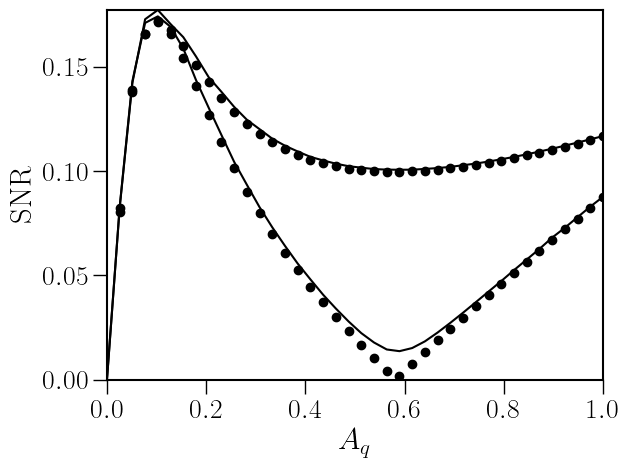

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for j, w_r in enumerate(wlist_cut_SNR):    
    ax.plot(Alist_cut_SNR, res_num_cut_SNR[:,j], c='black')
    ax.scatter(Alist_cut_SNR, res_an_cut_SNR[:,j], marker='o', c='black')

ax.set_xlabel(r'$A_q$')
ax.set_ylabel('SNR')

plt.show()

In [5]:
if save_file:
    fname = 'data/'+device+'/'+device+'_SNR_cut'

    np.savez(fname, wlist_cut_SNR=wlist_cut_SNR, Alist_cut_SNR=Alist_cut_SNR, res_an_cut_SNR=res_an_cut_SNR, res_num_cut_SNR=res_num_cut_SNR)